## 10.1 Examining the VAR model

The vector autoregression (VAR) model captures the relationship between multiple series as they change over time. In this model, each series has an impact on the other, unlike the SARIMAX model where the exogenous variable had an impact on the target, but not the other way around. Recall in chapter 9 that we used the variables realcons, realinv, realgovt, realdpi, cpi, m1, and tbilrate as predictors for realgdp, but we did not consider how realgdp can affect any of those variables. That is why we used the SARIMAX model in that case.

You might have noticed the return of autoregression, which brings us back to the AR(p) model of chapter 5. This is a good intuition, as the VAR model can be seen as a generalization of the AR(p) model to allow for the forecast of multiple time series. Therefore, we can also denote the VAR model as VAR(p), where p is the order and has the same meaning as in the AR(p) model.

Recall that AR(p) expressed the value of a time series as a linear combination of a constant C, the present error term ϵt, which is also white noise, and the past values of the series yt –p. The magnitude of the influence of the past values on the present value is denoted as φp, which represents the coefficients of the AR(p) model,
yt = C + φ1yt –1 + φ2yt –2 +⋅⋅⋅+ φpyt–p + ϵt 

We can simply extend equation 10.1 to allow for multiple time series to be modeled, where each has an impact on the others. For simplicity, let’s consider a system with two time series, denoted as y1,t and y2,t, and an order of 1, meaning that p = 1. Then, using matrix notation, the VAR(1) model can be expressed as equation 10.2.

## 10.3 Forecasting real disposable income and real consumption

Having examined the VAR(p) model and designed a modeling procedure for it, we are now ready to apply it to forecasting both the real disposable income and real consumption in the United States. We will use the same dataset as in the previous chapter, which contains the macroeconomics data between 1959 and 2009.

In [1]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


We can now plot our two variables of interest, which are real disposable income, denoted as realdpi in the dataset, and real consumption, denoted as realcons.

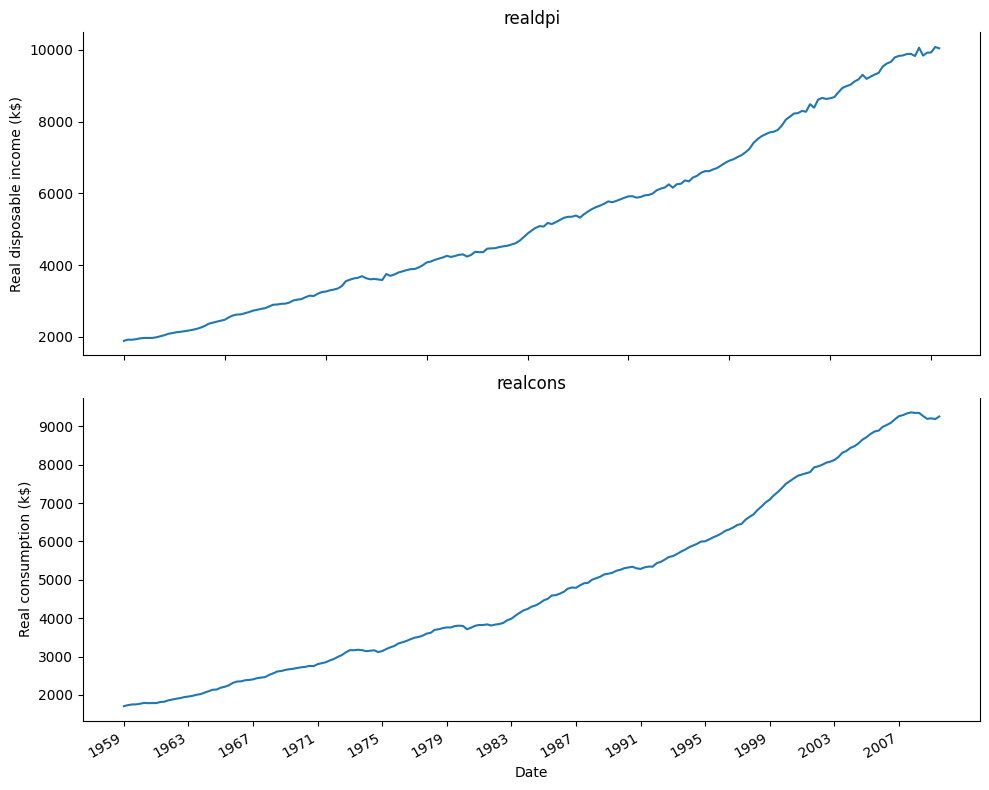

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)

ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

you can see that both curves have a very similar shape through time, which intuitively makes them good candidates for a VAR(p) model. It is reasonable to think that with a higher disposable income, consumption is likely to be high, just as higher consumption can be a sign of higher disposable income. Of course, this hypothesis will have to be tested using the Granger causality test later in the modeling procedure.

We have gathered the data, so now we must determine if the time series are stationary. In figure 10.3 both of them exhibit a positive trend through time, meaning that they are non-stationary. Nevertheless, we’ll apply the augmented Dickey-Fuller (ADF) test to make sure.

In [4]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: 2.986025351954683
p-value: 1.0

---------------------

realcons
ADF Statistic: 1.549912338050962
p-value: 0.9976992503412904


For both variables, the ADF test outputs a p-value of 1.0. Therefore, we cannot reject the null hypothesis, and we conclude that both time series are not stationary, as expected.

We’ll apply a transformation to make them stationary. Specifically, we’ll difference both series and test for stationarity again.

In [5]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: -8.864893340673005
p-value: 1.4493606159108354e-14

---------------------

realcons
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571


The ADF test for realdpi returns a p-value of 1.45 × 10–14, while the ADF test for realcons returns a p-value of 0.0006. In both cases, the p-value is smaller than 0.05. Therefore, we reject the null hypothesis and conclude that both time series are stationary.

As mentioned before, the VAR(p) model requires the time series to be stationary. We can thus use the transformed series for modeling, and we will need to integrate the forecasts to bring them back to their original scales.

We are now at the step of fitting many VAR(p) models to select the one with the smallest Akaike information criterion (AIC). We’ll write a function, optimize_VAR, to fit many VAR(p) models while varying the order p. This function will return an ordered DataFrame in ascending order of AIC. This function is shown in the following listing.

In [6]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.varmax import VARMAX

def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:
    
    results = []
    
    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
            
        aic = model.aic
        results.append([i, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

We can now use this function to select the order p that minimizes the AIC.

First, though, we must define the train and test sets. In this case, we’ll use 80% of the data for training and 20% for testing. This means that the last 40 data points will be used for testing, and the rest is used for training. Remember that the VAR(p) model requires both series to be stationary. Therefore, we’ll split on the differenced dataset and feed the differenced training set to the optimize_VAR function.

In [7]:
endog = macro_econ_data[['realdpi', 'realcons']]

endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]

result_df = optimize_VAR(train)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61849D+00    |proj g|=  2.88206D-03

At iterate    5    f=  9.61847D+00    |proj g|=  2.89229D-03

At iterate   10    f=  9.61834D+00    |proj g|=  3.17853D-03


 This problem is unconstrained.



At iterate   15    f=  9.61833D+00    |proj g|=  2.08535D-03

At iterate   20    f=  9.61831D+00    |proj g|=  7.03841D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     21     25      1     0     0   7.094D-05   9.618D+00
  F =   9.6183127884063637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58116D+00    |proj g|=  4.45022D-03


 This problem is unconstrained.



At iterate    5    f=  9.58112D+00    |proj g|=  2.53872D-03

At iterate   10    f=  9.58065D+00    |proj g|=  4.18744D-03

At iterate   15    f=  9.58061D+00    |proj g|=  7.55626D-04

At iterate   20    f=  9.58056D+00    |proj g|=  3.53042D-03

At iterate   25    f=  9.58054D+00    |proj g|=  3.50425D-04

At iterate   30    f=  9.58053D+00    |proj g|=  1.10723D-03

At iterate   35    f=  9.58053D+00    |proj g|=  9.97357D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     36     42      1     0     0   6.802D-05   9.581D+00
  F =   9.5805298396595404     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  9.53548D+00    |proj g|=  2.12456D-03

At iterate   10    f=  9.53459D+00    |proj g|=  1.00744D-02

At iterate   15    f=  9.53435D+00    |proj g|=  6.18730D-04

At iterate   20    f=  9.53427D+00    |proj g|=  6.00977D-03

At iterate   25    f=  9.53419D+00    |proj g|=  2.10889D-04

At iterate   30    f=  9.53418D+00    |proj g|=  6.47694D-04

At iterate   35    f=  9.53417D+00    |proj g|=  2.55971D-04

At iterate   40    f=  9.53417D+00    |proj g|=  7.88411D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     41     47      1     0     0   6.588D-05   9.534D+00
  F =   9.53416691145

 This problem is unconstrained.



At iterate    5    f=  9.53073D+00    |proj g|=  3.37638D-03

At iterate   10    f=  9.52882D+00    |proj g|=  5.77356D-03

At iterate   15    f=  9.52872D+00    |proj g|=  1.19733D-03

At iterate   20    f=  9.52848D+00    |proj g|=  6.53577D-03

At iterate   25    f=  9.52841D+00    |proj g|=  3.15814D-04

At iterate   30    f=  9.52840D+00    |proj g|=  2.43449D-04

At iterate   35    f=  9.52839D+00    |proj g|=  1.11785D-03

At iterate   40    f=  9.52838D+00    |proj g|=  4.60265D-04

At iterate   45    f=  9.52838D+00    |proj g|=  8.47363D-05

At iterate   50    f=  9.52838D+00    |proj g|=  1.51004D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.49065D+00    |proj g|=  3.71658D-03

At iterate   10    f=  9.48825D+00    |proj g|=  2.28030D-02

At iterate   15    f=  9.48729D+00    |proj g|=  1.02704D-03

At iterate   20    f=  9.48716D+00    |proj g|=  6.60107D-03

At iterate   25    f=  9.48680D+00    |proj g|=  6.00181D-04

At iterate   30    f=  9.48679D+00    |proj g|=  7.33762D-04

At iterate   35    f=  9.48679D+00    |proj g|=  8.50951D-04

At iterate   40    f=  9.48676D+00    |proj g|=  1.74286D-03

At iterate   45    f=  9.48675D+00    |proj g|=  1.30238D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     45     52   

 This problem is unconstrained.



At iterate    5    f=  9.47727D+00    |proj g|=  4.35159D-03

At iterate   10    f=  9.47491D+00    |proj g|=  2.97493D-02

At iterate   15    f=  9.47252D+00    |proj g|=  1.25347D-03

At iterate   20    f=  9.47249D+00    |proj g|=  2.06326D-03

At iterate   25    f=  9.47196D+00    |proj g|=  8.01780D-03

At iterate   30    f=  9.47183D+00    |proj g|=  4.76226D-04

At iterate   35    f=  9.47182D+00    |proj g|=  1.12198D-03

At iterate   40    f=  9.47181D+00    |proj g|=  1.76961D-03

At iterate   45    f=  9.47179D+00    |proj g|=  1.35885D-03

At iterate   50    f=  9.47178D+00    |proj g|=  8.86625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.47478D+00    |proj g|=  5.08595D-03

At iterate   10    f=  9.47087D+00    |proj g|=  2.26393D-02

At iterate   15    f=  9.46827D+00    |proj g|=  1.86585D-03

At iterate   20    f=  9.46823D+00    |proj g|=  1.91935D-03

At iterate   25    f=  9.46766D+00    |proj g|=  1.74466D-02

At iterate   30    f=  9.46737D+00    |proj g|=  1.13665D-03

At iterate   35    f=  9.46733D+00    |proj g|=  2.53912D-03

At iterate   40    f=  9.46732D+00    |proj g|=  4.80074D-04

At iterate   45    f=  9.46729D+00    |proj g|=  1.75629D-03

At iterate   50    f=  9.46728D+00    |proj g|=  4.79096D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.46428D+00    |proj g|=  5.80453D-03

At iterate   10    f=  9.46011D+00    |proj g|=  5.15625D-02

At iterate   15    f=  9.45574D+00    |proj g|=  5.77425D-03

At iterate   20    f=  9.45555D+00    |proj g|=  1.68747D-03

At iterate   25    f=  9.45505D+00    |proj g|=  2.55611D-02

At iterate   30    f=  9.45428D+00    |proj g|=  6.93953D-04

At iterate   35    f=  9.45427D+00    |proj g|=  1.84943D-03

At iterate   40    f=  9.45417D+00    |proj g|=  2.61391D-03

At iterate   45    f=  9.45416D+00    |proj g|=  3.11752D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     49     57   

 This problem is unconstrained.



At iterate    5    f=  9.45232D+00    |proj g|=  6.38271D-03

At iterate   10    f=  9.44644D+00    |proj g|=  4.04968D-02

At iterate   15    f=  9.44123D+00    |proj g|=  7.94194D-03

At iterate   20    f=  9.44106D+00    |proj g|=  1.85465D-03

At iterate   25    f=  9.44073D+00    |proj g|=  1.38197D-02

At iterate   30    f=  9.43957D+00    |proj g|=  3.90621D-03

At iterate   35    f=  9.43951D+00    |proj g|=  2.84479D-03

At iterate   40    f=  9.43944D+00    |proj g|=  1.22645D-03

At iterate   45    f=  9.43944D+00    |proj g|=  8.90550D-04

At iterate   50    f=  9.43940D+00    |proj g|=  3.79523D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           45     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45560D+00    |proj g|=  5.40566D-02

At iterate    5    f=  9.45433D+00    |proj g|=  7.10478D-03

At iterate   10    f=  9.44765D+00    |proj g|=  5.61137D-02

At iterate   15    f=  9.44028D+00    |proj g|=  6.79437D-03

At iterate   20    f=  9.44003D+00    |proj g|=  2.12372D-03

At iterate   25    f=  9.43938D+00    |proj g|=  1.05832D-02

At iterate   30    f=  9.43818D+00    |proj g|=  1.88869D-03

At iterate   35    f=  9.43804D+00    |proj g|=  5.13612D-03

At iterate   40    f=  9.43793D+00    |proj g|=  7.98029D-04

At iterate   45    f=  9.43789D+00    |proj g|=  2.65337D-03

At iterate   50    f=  9.43777D+00    |proj g|=  1.29706D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           49     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45195D+00    |proj g|=  5.62485D-02

At iterate    5    f=  9.45066D+00    |proj g|=  7.75022D-03

At iterate   10    f=  9.44280D+00    |proj g|=  4.86368D-02

At iterate   15    f=  9.43455D+00    |proj g|=  1.22417D-02

At iterate   20    f=  9.43304D+00    |proj g|=  2.39843D-03

At iterate   25    f=  9.43281D+00    |proj g|=  9.88912D-03

At iterate   30    f=  9.43078D+00    |proj g|=  1.44797D-02

At iterate   35    f=  9.43052D+00    |proj g|=  1.01802D-03

At iterate   40    f=  9.43051D+00    |proj g|=  1.46293D-03

At iterate   45    f=  9.43043D+00    |proj g|=  1.50580D-03

At iterate   50    f=  9.43042D+00    |proj g|=  6.94300D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.44350D+00    |proj g|=  8.47563D-03

At iterate   10    f=  9.43594D+00    |proj g|=  7.22624D-02

At iterate   15    f=  9.42532D+00    |proj g|=  2.94045D-02

At iterate   20    f=  9.42206D+00    |proj g|=  5.14442D-03

At iterate   25    f=  9.42186D+00    |proj g|=  5.32491D-03

At iterate   30    f=  9.42124D+00    |proj g|=  8.61518D-03

At iterate   35    f=  9.42043D+00    |proj g|=  8.07925D-03

At iterate   40    f=  9.41991D+00    |proj g|=  2.52500D-02

At iterate   45    f=  9.41893D+00    |proj g|=  8.12187D-03

At iterate   50    f=  9.41884D+00    |proj g|=  1.45740D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44502D+00    |proj g|=  6.32966D-02

At iterate    5    f=  9.44359D+00    |proj g|=  9.20343D-03

At iterate   10    f=  9.43572D+00    |proj g|=  6.09596D-02

At iterate   15    f=  9.42402D+00    |proj g|=  2.01438D-02

At iterate   20    f=  9.41891D+00    |proj g|=  9.92023D-03

At iterate   25    f=  9.41771D+00    |proj g|=  4.92434D-03

At iterate   30    f=  9.41759D+00    |proj g|=  6.83492D-03

At iterate   35    f=  9.41676D+00    |proj g|=  1.88239D-02

At iterate   40    f=  9.41482D+00    |proj g|=  6.28819D-03

At iterate   45    f=  9.41415D+00    |proj g|=  5.44998D-03

At iterate   50    f=  9.41388D+00    |proj g|=  1.58111D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43457D+00    |proj g|=  5.90786D-02

At iterate    5    f=  9.43308D+00    |proj g|=  1.01136D-02

At iterate   10    f=  9.42938D+00    |proj g|=  3.46586D-02

At iterate   15    f=  9.41121D+00    |proj g|=  5.62185D-02

At iterate   20    f=  9.40522D+00    |proj g|=  3.44054D-02

At iterate   25    f=  9.40284D+00    |proj g|=  1.18687D-02

At iterate   30    f=  9.40268D+00    |proj g|=  3.17947D-03

At iterate   35    f=  9.40192D+00    |proj g|=  1.39633D-02

At iterate   40    f=  9.39859D+00    |proj g|=  1.48435D-02

At iterate   45    f=  9.39821D+00    |proj g|=  1.29813D-03

At iterate   50    f=  9.39820D+00    |proj g|=  1.32422D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

,p,AIC
0,3,3123.070079
1,5,3123.708523
2,6,3126.855601
3,4,3129.194026
4,2,3130.091668
5,7,3133.398273
6,1,3134.333343
7,8,3137.149013
8,9,3140.367182
9,10,3147.838684


Running the function returns a DataFrame in which we see that p = 3 has the lowest AIC value of all. Therefore, the selected model is a VAR(3) model, meaning that the past three values of each time series are used to forecast the other time series.

Following the modeling procedure, we must now use the Granger causality test Recall that the VAR model assumes that past values of realcons are useful in predicting realdpi and that past values of realdpi are useful in predicting realcons. This relationship must be tested. If the Granger causality test returns a p-value greater than 0.05, we cannot reject the null hypothesis, meaning that the variables do not Grangercause each other, and the model is invalid. On the other hand, a p-value smaller than 0.05 will allow us to reject the null hypothesis, thus validating the VAR(3) model,meaning that we can move on with the modeling procedure.

We’ll run the Granger causality test for both variables, using the grangercausalitytests function from the statsmodels library. Remember that the series must be stationary for the Granger causality test, which is why they are differenced when passed in to the function. Also, we specify the number of lags for the test, which in this case is 3, since the model selection step returned p = 3.

In [8]:
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


Running the Granger causality test for both variables returns a p-value smaller than 0.05 in both cases. Therefore, we can reject the null hypothesis and conclude that realdpi Granger-causes realcons, and realcons Granger-causes realdpi. Our VAR(3) model is thus valid. In the event that one variable does not Granger-cause the other, the VAR(p) model becomes invalid, and it cannot be used. In that case, we must use the SARIMAX model and predict each time series individually.

We can now move on to residual analysis. For this step, we first fit the VAR(3) model on our train set.

In [9]:
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                              VAR(3)   Log Likelihood               -1544.535
                               + intercept   AIC                           3123.070
Date:                     Tue, 27 Sep 2022   BIC                           3175.559
Time:                             17:39:47   HQIC                          3144.381
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.03   Jarque-Bera (JB):          43.86, 4.35
Prob(Q):                        0.91, 0.87   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         4.44, 3.59   Skew:                      0.14

Then we can use the plot_diagnostics function to plot a histogram of the residuals, the Q-Q plot, and the correlogram. However, we must study the residuals of two variables here, since we are modeling both realdpi and realcons.

Let’s focus on the residuals for realdpi first.

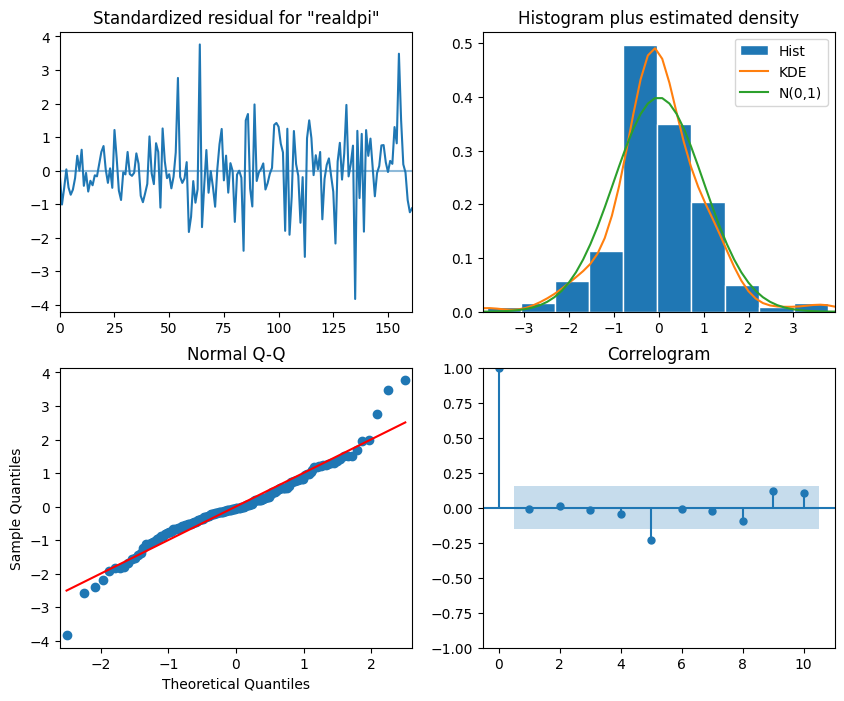

In [10]:
# realdpi
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

Now we can move on to analyzing the residuals of realcons.

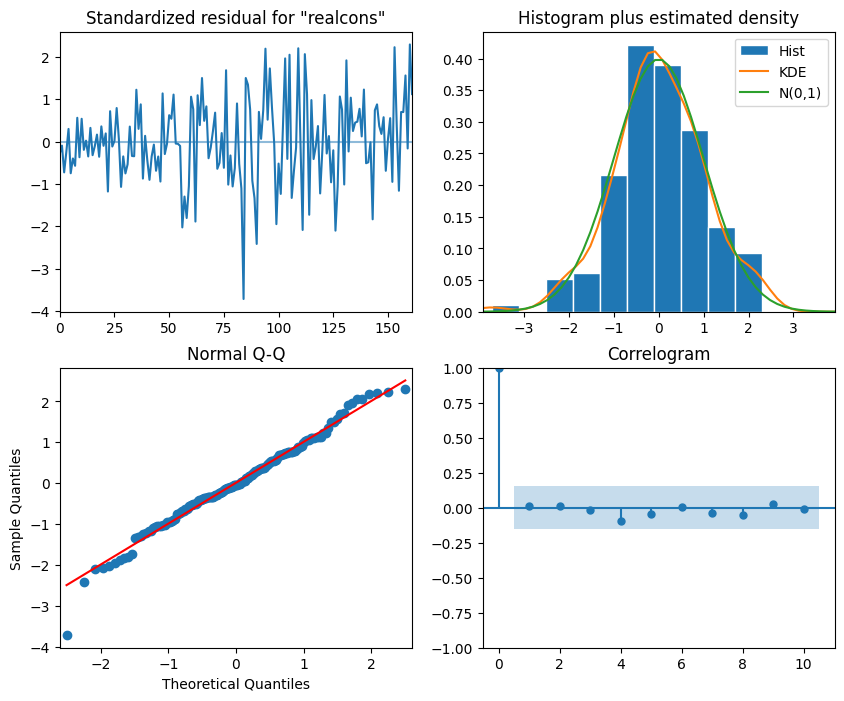

In [11]:
# realcons
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

Once the qualitative analysis is done, we can move on to the quantitative analysis using the Ljung-Box test.

In [13]:
realgdp_residuals = best_model_fit.resid['realdpi']

pvalue = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))

print(pvalue)

      lb_stat  lb_pvalue
1    0.011621   0.914154
2    0.029366   0.985424
3    0.075791   0.994575
4    0.377918   0.984245
5    9.142646   0.103508
6    9.165479   0.164483
7    9.270236   0.233832
8   10.811723   0.212597
9   13.318252   0.148726
10  15.287544   0.121925


In [14]:
realcons_residuals = best_model_fit.resid['realcons']

pvalue = acorr_ljungbox(realcons_residuals, np.arange(1, 11, 1))

print(pvalue)

     lb_stat  lb_pvalue
1   0.023915   0.877101
2   0.068635   0.966264
3   0.068713   0.995307
4   0.235657   0.993580
5   0.377730   0.995921
6   0.787349   0.992409
7   1.015323   0.994578
8   2.150554   0.976045
9   2.437225   0.982524
10  2.442889   0.991682


Since the model passed both the qualitative and quantitative aspects of residual analysis, we can move on to forecasting realcons and realdpi using a VAR(3) model.

We will compare the VAR(3) model to a baseline that simply predicts the last observed value. We’ll forecast four steps into the future, which is equivalent to forecasting one full year as the data is sampled quarterly. We’ll thus perform a rolling forecast four steps into the future over the entire length of the test set.

To do so, we’ll use the rolling_forecast function that we have defined many times over the last several chapters. This time, we’ll apply some slight modifications to accommodate the VAR(3) model. It will need to output predictions for both realdpi and realcons, so we must return two lists containing forecasts. The following listing shows the code for the rolling_forecast function.

In [16]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VAR':

        realdpi_pred_VAR = []
        realcons_pred_VAR = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VAR.extend(oos_pred_realdpi)
            realcons_pred_VAR.extend(oos_pred_realcons)
        
        return realdpi_pred_VAR, realcons_pred_VAR
    
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last, realcons_pred_last

We can now use this function to produce the forecasts for realdpi and realcons using the VAR(3) model.

In [18]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')

Recall that the VAR(3) model requires the series to be stationary, meaning that we have transformed forecasts. We must then integrate them using the cumulative sum to bring them back to the original scale of the data.

In [19]:
test = endog[163:]

test['realdpi_pred_VAR'] = pd.Series()
test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR)

test['realcons_pred_VAR'] = pd.Series()
test['realcons_pred_VAR'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR)

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR
163,7887.7,7389.2,7829.223826,7354.325367
164,8053.4,7501.3,7897.187649,7430.256283
165,8135.9,7571.8,7960.561470,7496.630419
166,8222.3,7645.9,8014.754801,7556.616396
167,8234.6,7713.5,8080.700705,7631.006287
168,8296.5,7744.3,8142.391228,7692.859015
169,8273.7,7773.5,8200.122253,7753.883781
170,8484.5,7807.7,8259.363570,7812.558165
171,8385.5,7930.0,8264.387527,7864.658784
172,8611.6,7957.3,8320.859936,7895.083535


At this point, test contains the actual values of the test set and the predictions from the VAR(3) model. We can now add the forecasts from our baseline method, which simply predicts the last known value for the next four timesteps.

In [21]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.223826,7354.325367,7716.0,7199.9
164,8053.4,7501.3,7897.187649,7430.256283,7716.0,7199.9
165,8135.9,7571.8,7960.561470,7496.630419,7716.0,7199.9
166,8222.3,7645.9,8014.754801,7556.616396,7716.0,7199.9
167,8234.6,7713.5,8080.700705,7631.006287,8135.9,7571.8
168,8296.5,7744.3,8142.391228,7692.859015,8135.9,7571.8
169,8273.7,7773.5,8200.122253,7753.883781,8135.9,7571.8
170,8484.5,7807.7,8259.363570,7812.558165,8135.9,7571.8
171,8385.5,7930.0,8264.387527,7864.658784,8273.7,7773.5
172,8611.6,7957.3,8320.859936,7895.083535,8273.7,7773.5


Now test holds the actual values of the test set, the predictions from the VAR(3) model, and the predictions from the baseline method. Everything is set for us to visualize the forecasts and evaluate the forecasting methods using the mean absolute percentage error (MAPE).

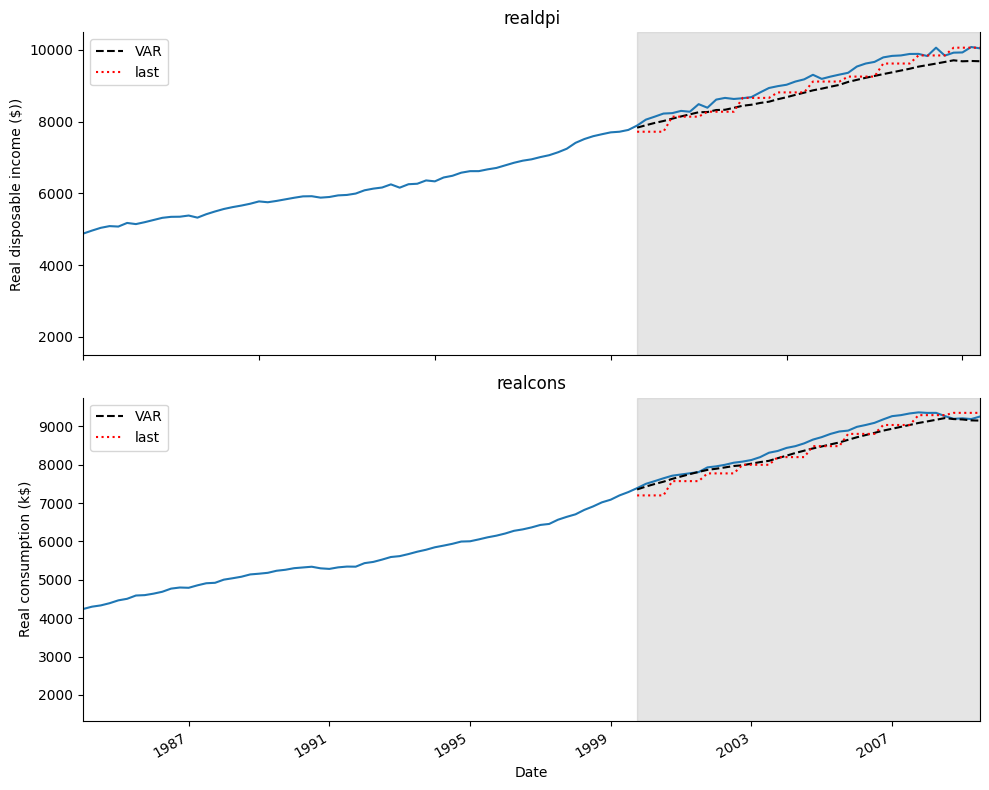

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VAR'], 'k--', label='VAR')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VAR'], 'k--', label='VAR')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)

fig.autofmt_xdate()
plt.tight_layout()

In figure 10.6 the dashed line represents the forecasts from the VAR(3) model, and the dotted line shows the predictions from the last known value method. You can see that both lines are very close to the actual values of the test set, making it hard for us to visually determine which method is better.

We will now calculate the MAPE.

In [23]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
mape_realdpi_VAR = mape(test['realdpi'], test['realdpi_pred_VAR'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VAR = mape(test['realcons'], test['realcons_pred_VAR'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

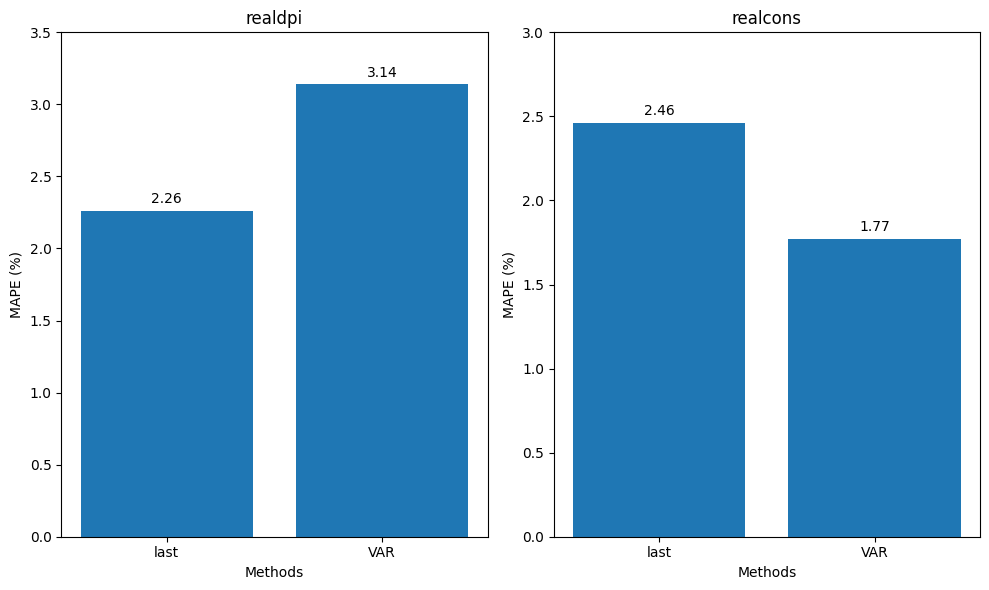

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR']
y1 = [mape_realdpi_last, mape_realdpi_VAR]
y2 = [mape_realcons_last, mape_realcons_VAR]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

In figure 10.7 you can see that the VAR(3) model performs worse than the baseline in the case of realdpi but better than the baseline for realcons. This is an ambiguous situation. There is no clear result, since the model does not outperform the baseline
in both situations.

We can hypothesize that in the case of realdpi, realcons is not predictive enough to make more accurate forecasts than the baseline, even though the Granger causality test passed. Therefore, we should resort to using a variation of the SARIMAX model to predict realdpi. Thus, I would conclude that the VAR(3) model is not sufficient to accurately forecast realdpi and realcons. I would suggest using two separate models, which could include realdpi and realcons as exogenous variables, while also potentially including moving average terms.